Initial Split Complete. Training samples: 4355


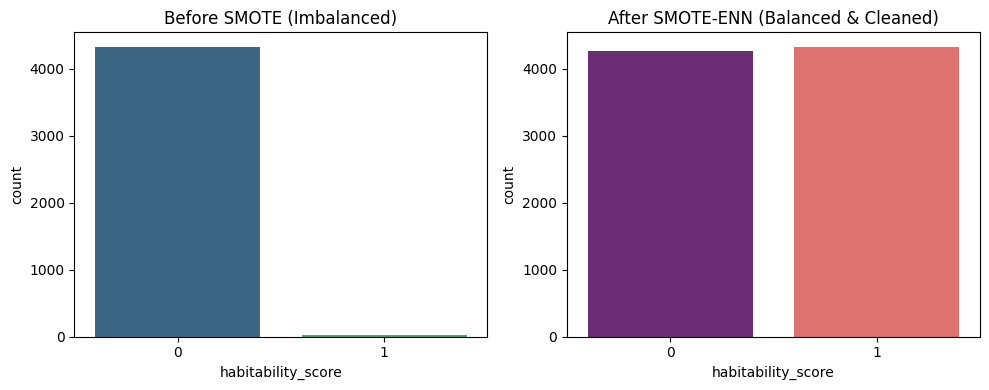

Data Successfully Balanced and Cleaned: Counter({1: 4330, 0: 4269})
Milestone 3 Upgrade Complete. Files are now higher quality for training.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
# UPGRADE: Using SMOTEENN for cleaner decision boundaries
from imblearn.combine import SMOTEENN 
from collections import Counter

# Load the refined exoplanet dataset
df_scaled = pd.read_csv('final-preprocessed-updated.csv')

# ==========================================
# PHASE 1: TARGET DEFINITION & LEAKAGE CONTROL
# ==========================================
# DETECTIVE RULE: We drop the pillars used in the calculation to force 
# the AI to find habitability using indirect stellar clues[cite: 23, 57].
leaky_pillars = ['pl_rade', 'pl_insol', 'pl_eqt', 'pl_orbeccen']
identifiers = ['pl_name', 'hostname', 'st_spectype', 'discoverymethod']

X = df_scaled.drop(columns=leaky_pillars + identifiers + ['habitability_score'])
y = df_scaled['habitability_score']

# Create a stratification mask for the 80/20 split [cite: 10, 11]
y_stratify_mask = (y > 0.7).astype(int)

# ==========================================
# PHASE 2: STRATIFIED TRAIN-TEST SPLIT (80/20)
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_stratify_mask
)

print(f"Initial Split Complete. Training samples: {len(X_train)}")

# ==========================================
# PHASE 3: CORRELATION & MULTI-COLLINEARITY (VIF)
# ==========================================
corr_matrix = X_train.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.85)]

def calculate_vif(df_vif):
    df_vif = df_vif.loc[:, df_vif.std() > 0]
    vif_df = pd.DataFrame()
    vif_df["feature"] = df_vif.columns
    vif_df["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]
    return vif_df.sort_values(by="VIF", ascending=False)

features_to_prune = list(set(to_drop_corr + ['pl_cmasse', 'pl_msinie', 'sy_gaiamag', 'sy_w1mag']))
X_train_pruned = X_train.drop(columns=[f for f in features_to_prune if f in X_train.columns])
X_test_pruned = X_test.drop(columns=[f for f in features_to_prune if f in X_test.columns])

# ==========================================
# PHASE 4: HYBRID SYNTHETIC GENERATION (SMOTE-ENN)
# ==========================================
# We combine X and continuous y to resample both, then clean noisy overlaps.
X_combined = pd.concat([X_train_pruned, y_train.rename('reg_target')], axis=1)
y_train_bin = (y_train > 0.7).astype(int) 

# SMOTE-ENN Upgrade: Oversamples the 'Gems' and then removes noisy/overlapping points.
sme = SMOTEENN(random_state=42)
X_res_combined, y_train_res_bin = sme.fit_resample(X_combined, y_train_bin)

# Separate the cleaned, resampled features from the regression scores
X_train_res = X_res_combined.drop(columns=['reg_target'])
y_train_res_reg = X_res_combined['reg_target']

# ==========================================
# PHASE 5: EXPORT FOR MILESTONE 4
# ==========================================
# Saving all 5 synchronized files for the stacking phase[cite: 108].
X_train_res.to_csv('X_train_final.csv', index=False)
y_train_res_bin.to_csv('y_train_final.csv', index=False)      
y_train_res_reg.to_csv('y_train_regression.csv', index=False) 
X_test_pruned.to_csv('X_test_final.csv', index=False)         
y_test.to_csv('y_test_final.csv', index=False)               

# ==========================================
# PHASE 6: FINAL VISUALIZATION
# ==========================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_bin, hue=y_train_bin, palette='viridis', legend=False)
plt.title("Before SMOTE (Imbalanced)")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_res_bin, hue=y_train_res_bin, palette='magma', legend=False)
plt.title("After SMOTE-ENN (Balanced & Cleaned)")
plt.tight_layout()
plt.show()

print(f"Data Successfully Balanced and Cleaned: {Counter(y_train_res_bin)}")